# Импорты

In [1]:
!pip install tensorflow[and-cuda]

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 40.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 35.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 17.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 4.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 957.4 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 4.6 MB/s eta 0:00:0000:0100:01

In [66]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import random

from datasets import load_dataset
from datasets import Dataset
from datasets import Image as DatasetsImage
from datasets import DatasetDict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
import os
from PIL import Image

from keras.utils import Sequence
from tensorflow.keras.optimizers import AdamW
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Данные

In [3]:
dataset = load_dataset("flaviagiammarino/path-vqa")
dataset.save_to_disk("/kaggle/working/dataset")

Generating train split:   0%|          | 0/19654 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6259 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6719 [00:00<?, ? examples/s]

Saving the dataset (0/8 shards):   0%|          | 0/19654 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/6259 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/6719 [00:00<?, ? examples/s]

In [6]:
df_train_class_task = pd.read_csv('/kaggle/input/tables/multitarget_train.csv')
df_valid_class_task = pd.read_csv('/kaggle/input/tables/multitarget_valid.csv')
df_test_class_task = pd.read_csv('/kaggle/input/tables/multitarget_test.csv')

In [7]:
df_train_class_task.head()

,image_path,target
0,/kaggle/input/images-path-vqa/images/train/ima...,gastrointestinal
1,/kaggle/input/images-path-vqa/images/train/ima...,gastrointestinal
2,/kaggle/input/images-path-vqa/images/train/ima...,gastrointestinal
3,/kaggle/input/images-path-vqa/images/train/ima...,gastrointestinal
4,/kaggle/input/images-path-vqa/images/train/ima...,gastrointestinal


In [6]:
train_paths = df_train_class_task.image_path.values.tolist()
valid_paths = df_valid_class_task.image_path.values.tolist()
test_paths = df_test_class_task.image_path.values.tolist()

paths_multitarget = train_paths + valid_paths + test_paths

if not os.path.exists("/kaggle/working/images"):
    os.makedirs('/kaggle/working/images')

for split in dataset.keys():
    for i, obj in enumerate(tqdm(dataset[split], desc=f"Processing {split}")):
        img_path = dataset[split].cast_column("image", DatasetsImage(decode=False))[i]['image']['path']
        if img_path in paths_multitarget:
            obj['image'].save(f"/kaggle/working/images/{img_path}")

df_train, df_valid, df_test = df_train_class_task.copy(), df_valid_class_task.copy(), df_test_class_task.copy()
df_train['image_path'] = df_train['image_path'].apply(lambda x: "/kaggle/working/images/"+ x)
df_valid['image_path'] = df_valid['image_path'].apply(lambda x: "/kaggle/working/images/"+ x)
df_test['image_path'] = df_test['image_path'].apply(lambda x: "/kaggle/working/images/"+ x)

Processing test: 100%|██████████| 6719/6719 [01:33<00:00, 72.24it/s] 


# Подготовка

**IMAGES**

In [11]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [12]:
batch_size = 32

images_train = []
for i in tqdm(range(0, len(df_train), batch_size), desc="Обработка изображений"):
    batch_paths = df_train['image_path'][i:i+batch_size]
    batch_images = [preprocess_image(img_path) for img_path in batch_paths]
    images_train.extend(batch_images)

images_train = np.vstack(images_train).astype('float32')

Обработка изображений: 100%|██████████| 156/156 [01:04<00:00,  2.41it/s]


In [13]:
images_valid = []
for i in tqdm(range(0, len(df_valid), batch_size), desc="Обработка изображений"):
    batch_paths = df_valid['image_path'][i:i+batch_size]
    batch_images = [preprocess_image(img_path) for img_path in batch_paths]
    images_valid.extend(batch_images)

images_valid = np.vstack(images_valid).astype('float32')

Обработка изображений: 100%|██████████| 34/34 [00:13<00:00,  2.59it/s]


In [14]:
images_test = []
for i in tqdm(range(0, len(df_test), batch_size), desc="Обработка изображений"):
    batch_paths = df_test['image_path'][i:i+batch_size]
    batch_images = [preprocess_image(img_path) for img_path in batch_paths]
    images_test.extend(batch_images)

images_test = np.vstack(images_test).astype('float32')

Обработка изображений: 100%|██████████| 34/34 [00:13<00:00,  2.55it/s]


**LABELS**

In [15]:
target_train = df_train_class_task['target'].values.tolist()
target_valid = df_valid_class_task['target'].values.tolist()
target_test = df_test_class_task['target'].values.tolist()

In [16]:
le = LabelEncoder()
labels_train = le.fit_transform(target_train)
labels_test = le.transform(target_test)
labels_valid = le.transform(target_valid)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

ids_train = df_train_class_task['target'].index
ids_test = df_test_class_task['target'].index
ids_valid = df_test_class_task['target'].index

labels_train_encoded = to_categorical(labels_train, num_classes=22)
labels_test_encoded = to_categorical(labels_test, num_classes=22)
labels_valid_encoded = to_categorical(labels_valid, num_classes=22)

In [17]:
X_train = images_train
X_valid = images_valid
X_test = images_test

In [18]:
y_train = labels_train_encoded
y_valid = labels_valid_encoded
y_test = labels_test_encoded

# CNN with ResNet top layers

In [19]:
batch_size = 64

In [37]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224, 3))

for layer in base_model.layers:
    layer.trainable = False


def create_and_compile_model(optimizer):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(22, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


model_resnet = create_and_compile_model(optimizer='adam')

In [38]:
history_resnet = model_resnet.fit(X_train, y_train, batch_size=batch_size,
                                  steps_per_epoch=len(X_train) // batch_size,
                                  epochs=30,
                                  validation_data=(X_valid, y_valid))

Epoch 1/30
 1/77 ━━━━━━━━━━━━━━━━━━━━ 13:33 11s/step - accuracy: 0.0625 - loss: 4.3553

W0000 00:00:1723620951.173439     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2960 - loss: 2.7160

W0000 00:00:1723620968.670894     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 285ms/step - accuracy: 0.2974 - loss: 2.7076 - val_accuracy: 0.4981 - val_loss: 1.5213
Epoch 2/30


W0000 00:00:1723620972.935632     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/77 ━━━━━━━━━━━━━━━━━━━━ 4:37 4s/step - accuracy: 0.5532 - loss: 1.3127

W0000 00:00:1723620976.532222     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5532 - loss: 1.3127 - val_accuracy: 0.5103 - val_loss: 1.5116
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.5669 - loss: 1.2546 - val_accuracy: 0.5827 - val_loss: 1.2398
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7021 - loss: 0.8317 - val_accuracy: 0.5771 - val_loss: 1.2462
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.6501 - loss: 0.9478 - val_accuracy: 0.6175 - val_loss: 1.1364
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6809 - loss: 0.9284 - val_accuracy: 0.6128 - val_loss: 1.1294
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.6735 - loss: 0.8444 - val_accuracy: 0.6391 - val_loss: 1.0642
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6809 - loss: 0.6654 - val_accuracy: 0.6391 - val_loss: 1.0648
Epoch 9/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.6988 - loss: 0.7217 - val_accuracy: 0.6560 - val_

In [39]:
predictions_resnet = model_resnet.predict(X_test)
predicted_resnet_class_indices = np.argmax(predictions_resnet, axis=1)

score_resnet = model_resnet.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score_resnet[0])
print('Test accuracy:', score_resnet[1])

 3/34 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step

W0000 00:00:1723621276.088537     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step


W0000 00:00:1723621281.944474     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723621285.278209     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test loss: 0.8706870079040527
Test accuracy: 0.7007366418838501


W0000 00:00:1723621289.677812     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [41]:
model_resnet.save('model_resnet.keras')

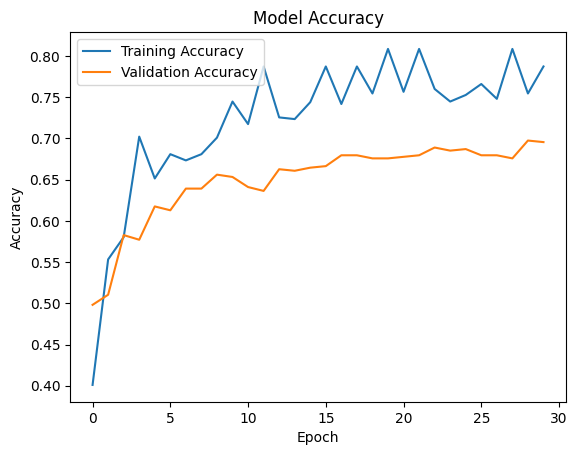

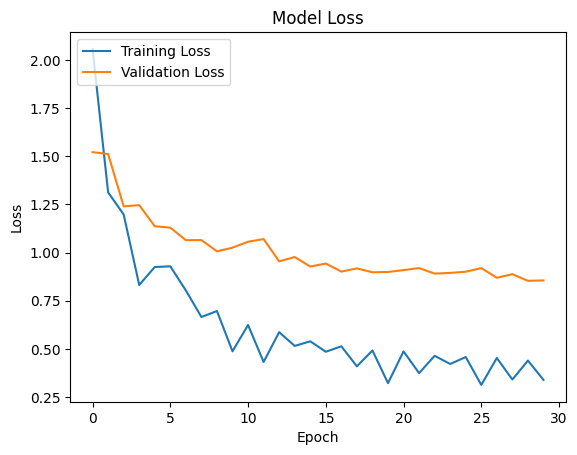

In [42]:
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

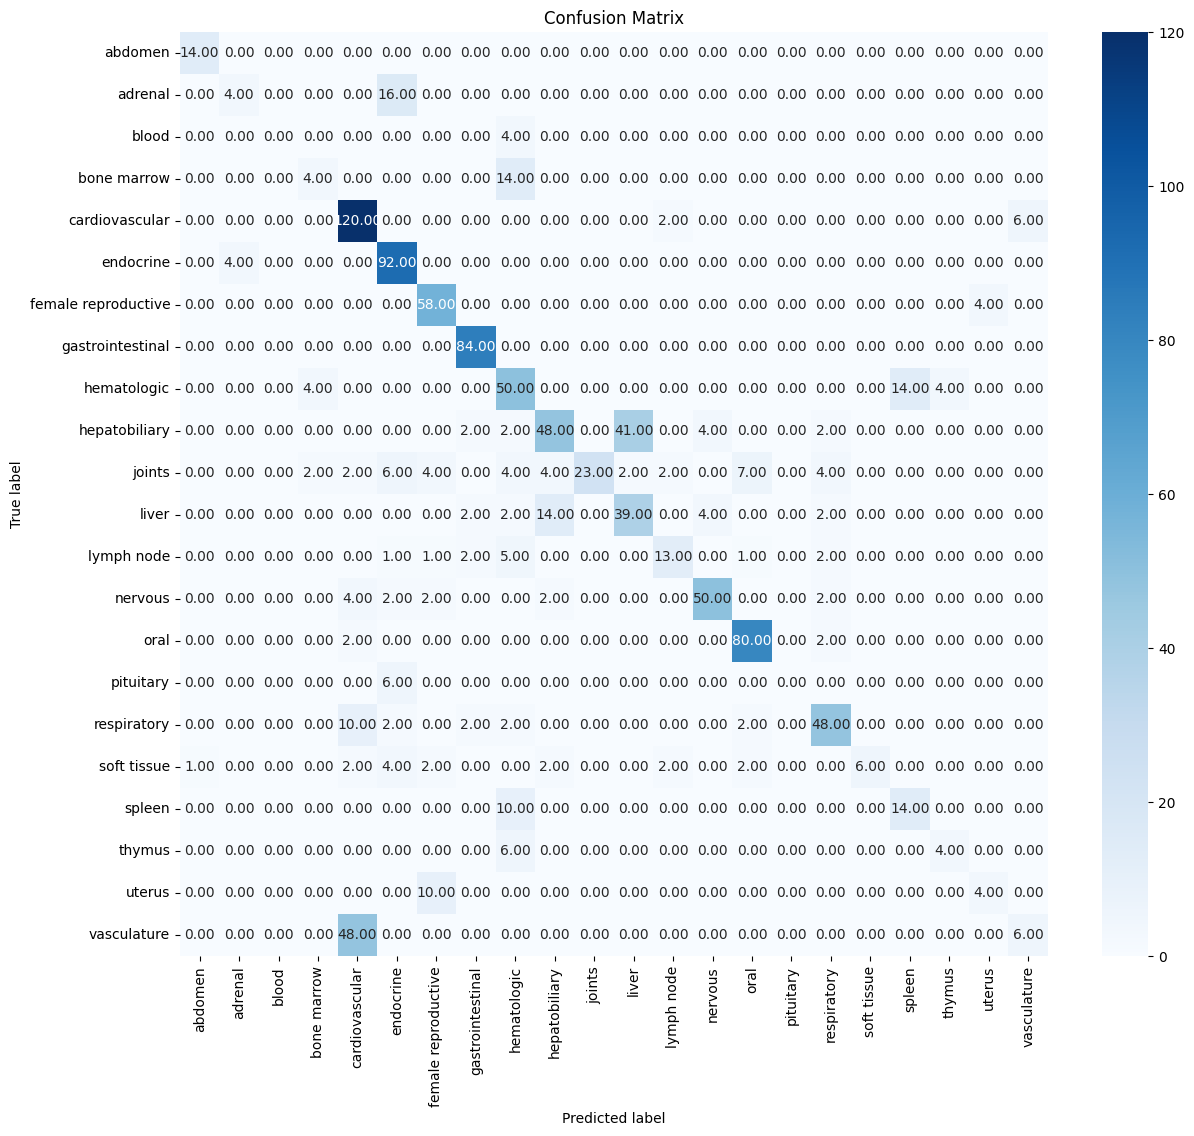

In [61]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()

    
predictions = np.array(predicted_resnet_class_indices)
true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_labels, predictions)

plot_confusion_matrix(cm, classes=le_name_mapping)

Видим, что модель плохо справляется с классами adrenal, blood, bone_marrow, pituitary, soft_tissue, thymus, uterus + путает классы сосудистой и сердечно-сосудистой системы (vasculature и cardiovascular). 

Выход -- расширить обучающий набор данных в этих классах.

# Augmentation

Попробуем обучить модель на аугментированных данных.

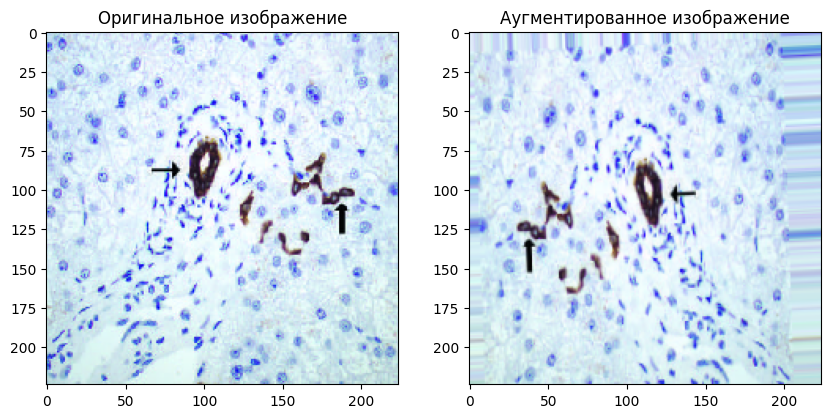

In [64]:
def load_and_display_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array[0].astype('uint8'))
    plt.title("Оригинальное изображение")
    
    datagen = ImageDataGenerator(rotation_range=20, 
                                 width_shift_range=0.2, 
                                 height_shift_range=0.2, 
                                 shear_range=0.2, 
                                 zoom_range=0.2, 
                                 horizontal_flip=True, 
                                 fill_mode='nearest')
    
    augmented_images = next(datagen.flow(img_array, batch_size=1))

    plt.subplot(1, 2, 2)
    plt.imshow(augmented_images[0].astype('uint8'))
    plt.title("Аугментированное изображение")
    
    plt.show()

load_and_display_image('/kaggle/input/images-path-vqa/images/train/image_0.jpg')

In [68]:
datagen = ImageDataGenerator(rotation_range=20, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.2, 
                             horizontal_flip=True, 
                             fill_mode='nearest')

model_resnet_aug = create_and_compile_model(optimizer='adam')

history_resnet_aug = model_resnet_aug.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                                 steps_per_epoch=len(X_train) // batch_size,
                                 epochs=30,
                                 validation_data=(X_valid, y_valid))

Epoch 1/30
 1/77 ━━━━━━━━━━━━━━━━━━━━ 19:46 16s/step - accuracy: 0.0312 - loss: 4.1720

W0000 00:00:1723624438.457152     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 5/77 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.0757 - loss: 4.3143  

W0000 00:00:1723624444.191746     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.2531 - loss: 2.9828

W0000 00:00:1723624491.056662     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 72s 748ms/step - accuracy: 0.2542 - loss: 2.9746 - val_accuracy: 0.4211 - val_loss: 1.8740
Epoch 2/30
 1/77 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.3750 - loss: 1.8454

W0000 00:00:1723624495.460334     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3750 - loss: 1.8454 - val_accuracy: 0.4229 - val_loss: 1.8591
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 54s 641ms/step - accuracy: 0.4590 - loss: 1.6596 - val_accuracy: 0.4831 - val_loss: 1.6302
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4531 - loss: 1.6085 - val_accuracy: 0.4793 - val_loss: 1.6464
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 53s 630ms/step - accuracy: 0.5359 - loss: 1.4089 - val_accuracy: 0.5207 - val_loss: 1.5576
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4844 - loss: 1.3374 - val_accuracy: 0.5207 - val_loss: 1.5568
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 54s 643ms/step - accuracy: 0.5705 - loss: 1.2238 - val_accuracy: 0.5367 - val_loss: 1.4113
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5106 - loss: 1.0923 - val_accuracy: 0.5385 - val_loss: 1.4201
Epoch 9/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 56s 668ms/step - accuracy: 0.5850 - loss: 1.1294 - val_accuracy: 0.5592 - val_

In [69]:
test_loss, test_acc = model_resnet_aug.evaluate(X_test, y_test, batch_size=batch_size)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

 1/17 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2812 - loss: 3.3917

W0000 00:00:1723625634.619330     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 969ms/step - accuracy: 0.5937 - loss: 1.4409
Test accuracy: 0.5985267162322998
Test loss: 1.2983742952346802


W0000 00:00:1723625650.192231     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


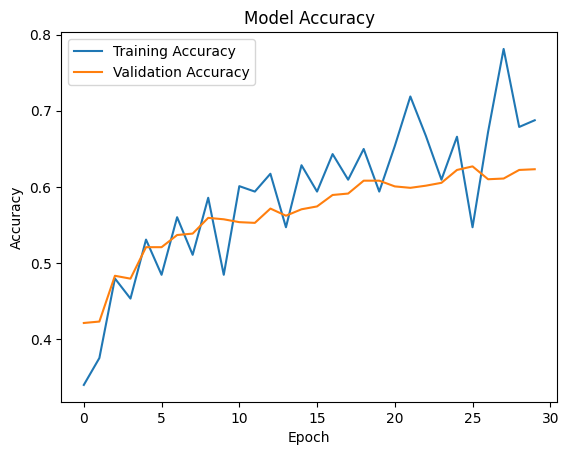

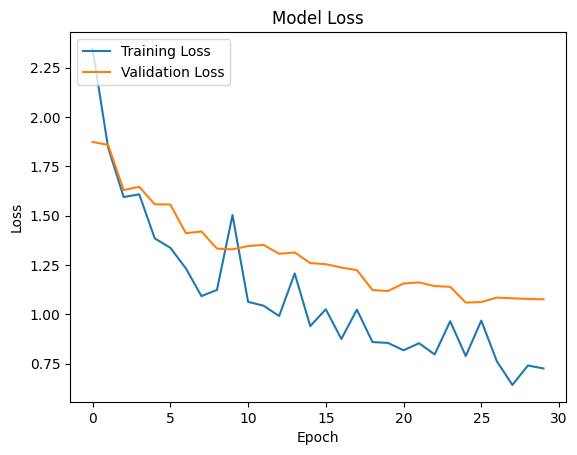

In [70]:
plt.plot(history_resnet_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history_resnet_aug.history['loss'], label='Training Loss')
plt.plot(history_resnet_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

На аугментированных данных модель обучается медленнее и выдает более низкое качество.